In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import json
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
from shapely.geometry import Point, Polygon
from area import area
from sklearn import neighbors

%matplotlib inline

In [4]:
postmates = pd.read_csv('/Users/baileyrusso/PycharmProjects/GrubHubScraper/postmates_all6.csv')
postmates = postmates.loc[:, ~postmates.columns.str.contains('^Unnamed')]

# Categories with most favorites

In [7]:
groupedCat = postmates.groupby('Category').aggregate('mean').sort_values('Favorites',ascending=False).head(25)
groupedCat

,Favorites,MenuItemPrice,Latitude,Longitude
Category,,,,
MAC & CHEESE,617.000000,13.557246,40.730168,-73.983649
SOUTHERN,579.000000,5.052121,40.723624,-73.978938
DIM SUM,404.138889,17.240223,40.776882,-73.966129
LATIN AMERICAN,354.391304,8.398098,40.720107,-73.993666
KOREAN,339.143533,15.539005,40.731784,-73.985089
SHANGHAI,330.000000,17.365854,40.668645,-73.993636
VEGAN,286.212160,9.581808,40.753738,-73.982142
ACAI,266.504505,11.728604,40.749761,-73.996343
DESSERT,238.569752,15.728885,40.759950,-73.980115


# Restaurants with Most Favorites

In [8]:
groupedName = postmates.groupby('Name').aggregate('mean').sort_values('Favorites',ascending=False).head(25)
groupedName

,Favorites,MenuItemPrice,Latitude,Longitude
Name,,,,
KazuNori | The Original Handroll Bar,3300.000000,16.570000,40.659813,-74.001266
SUGARFISH,1900.000000,19.974490,NaN,NaN
The Halal Guys,1113.308411,6.243269,40.763061,-73.977303
Philippe Chow,1000.000000,30.328125,40.764192,-73.970314
Bondi Sushi - Nomad,1000.000000,8.310345,40.744668,-73.987560
Thai Villa,928.469945,14.081967,40.738981,-73.990706
Bonchon Chicken,774.000000,11.190000,40.747406,-73.985097
Grace Street,765.000000,11.926579,NaN,NaN
The Butcher's Daughter,757.000000,8.900000,40.720716,-73.994785


# Checking Relationship b/w Menu Item Price and Num Favorites

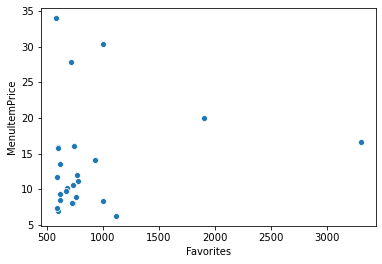

In [10]:
sns.scatterplot('Favorites','MenuItemPrice',data=groupedName,)

# Most Popular Categories

In [17]:
postmates.groupby(['Category','Name']).count().reset_index()['Category'].value_counts()

AMERICAN         57
PIZZA            46
ITALIAN          35
DELI             35
BURGER           25
                 ..
NEW AMERICAN      1
FROZEN YOGURT     1
SHANGHAI          1
KOSHER            1
MAC & CHEESE      1
Name: Category, Length: 76, dtype: int64

# Checking Relationship b/w Favorites and Number of Menu Items

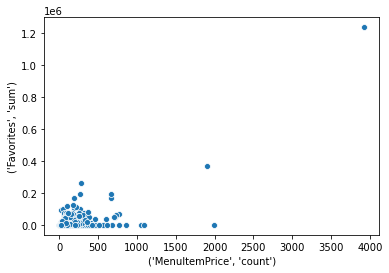

In [51]:
groupedNumItems = postmates.groupby('Name').aggregate(['count','sum'])[[('Favorites','sum'),('MenuItemPrice','count')]]#.sort_values('MenuItem',ascending=False)

sns.scatterplot(('MenuItemPrice','count'), ('Favorites','sum'), data=groupedNumItems)


In [53]:
groupedNumItems.corr()

,,Favorites,MenuItemPrice
,,sum,count
Favorites,sum,1.000000,0.721534
MenuItemPrice,count,0.721534,1.000000


# Most Popular Menu Items Sold

In [77]:
postmates.groupby('MenuItem').aggregate(['mean','sum','count']).sort_values(('MenuItemPrice','count'),ascending=False).head(60)


Favorites                MenuItemPrice                 \
                           mean      sum count          mean      sum count   
MenuItem                                                                      
French Fries          77.005128  15016.0   195      5.104479   980.06   192   
Onion Rings           58.661871   8154.0   139      6.293333   849.60   135   
Iced Tea              63.916667   8437.0   132      3.144480   393.06   125   
Soda                 120.812500  13531.0   112      2.329464   260.90   112   
Caesar Salad          98.518519  10640.0   108     11.483679  1217.27   106   
Mozzarella Sticks     70.490566   7472.0   106      9.526214   981.20   103   
Iced Coffee           67.194444   7257.0   108      3.270874   336.90   103   
Lemonade              47.947917   4603.0    96      3.285054   305.51    93   
Bottled Water        138.336957  12727.0    92      2.326667   209.40    90   
Diet Coke (can)        0.000000      0.0    85      2.311059   196.44    85   
Coke (can)             0.000000      0.0    83      2.312530   191.94    83   
Sweet Potato Fries    67.814815   5493.0    81      6.820988   552.50    81   
Brown Rice           112.641975   9124.0    81      2.930370   237.36    81   
Water (bottle)         3.000000    240.0    80      2.387250   190.98    80   
Snapple              117.294872   9149.0    78      2.942308   229.50    78   
Greek Salad           74.354430   5874.0    79     12.514615   976.14    78   
Cappuccino           101.847059   8657.0    85      3.847051   300.07    78   
Coffee                62.460526   4747.0    76      2.802237   212.97    76   
Thai Iced Tea         59.368421   4512.0    76      4.157500   315.97    76   
Sprite (can)           0.000000      0.0    72      2.253750   162.27    72   
Espresso             110.666667   7304.0    66      3.373594   215.91    64   
Orange Juice          76.261538   4957.0    65      4.601094   294.47    64   
Hot Chocolate         74.445946   5509.0    74      3.459524   217.95    63   
Coke                 100.209677   6213.0    62      2.428226   150.55    62   
Cheese Fries          83.714286   5274.0    63      6.980820   425.83    61   
Tea                   52.901639   3227.0    61      2.502034   147.62    59   
Chicken Satay        118.745763   7006.0    59      8.410847   496.24    59   
Cheeseburger          88.121212   5816.0    66      8.414310   488.03    58   
Gatorade             108.153846   7030.0    65      2.889455   158.92    55   
Diet Coke Can         71.090909   3910.0    55      3.039091   167.15    55   
Carrot Cake           96.800000   5324.0    55      6.630545   364.68    55   
White Rice           152.055556   8211.0    54      2.804259   151.43    54   
Turkey Burger         55.000000   2915.0    53      9.364906   496.34    53   
Fried Calamari        79.056604   4190.0    53     13.693396   725.75    53   
Curly Fries           38.365385   1995.0    52      6.743400   337.17    50   
Latte                 85.500000   4617.0    54      4.097000   204.85    50   
Veggie Burger         65.408163   3205.0    49      9.505918   465.79    49   
Edamame              121.387755   5948.0    49      6.218571   304.71    49   
Ginger Ale (can)       0.000000      0.0    47      2.245745   105.55    47   
Bacon Cheeseburger    62.787234   2951.0    47      9.701702   455.98    47   
Home Fries            40.204082   1970.0    49      5.204255   244.60    47   
Diet Coke            215.645833  10351.0    48      2.593696   119.31    46   
Sprite (bottle)        0.000000      0.0    43      2.978140   128.06    43   
Coke (bottle)          0.000000      0.0    43      2.978140   128.06    43   
French Toast          63.860465   2746.0    43      8.866512   381.26    43   
Pepsi (can)            0.000000      0.0    43      2.250698    96.78    43   
Tiramisu             150.953488   6491.0    43      8.341395   358.68    43   
Diet Coke (bottle)     0.000000      0.0    43      2.978140   128.06   

# Distrubution of Popular Menu Item Prices

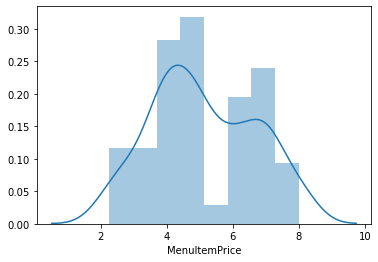

In [71]:
sns.distplot(postmates[postmates['MenuItem'] == 'French Fries']['MenuItemPrice'])

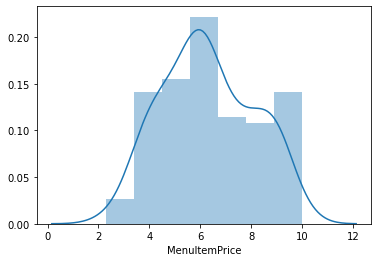

In [72]:
sns.distplot(postmates[postmates['MenuItem'] == 'Onion Rings']['MenuItemPrice'])

In [76]:
postmates[postmates['MenuItem'] == 'French Fries'].sort_values('MenuItemPrice').head(20)

,Name,Category,Favorites,Address,MenuItem,MenuItemDescription,MenuItemPrice,Address_Coordinates,Latitude,Longitude
48918,"b""Wendys""",FAST FOOD,161.0,20 E 14TH STREET,French Fries,"Natural-cut, skin-on, sea-salted fries served ...",2.25,"(40.735443, -73.992632)",40.735443,-73.992632
1639,Wendy's,FAST FOOD,51.0,85 NASSAU STREET,French Fries,"Natural-cut, skin-on, sea-salted fries served ...",2.25,"(nan,)",NaN,NaN
1693,Wendy's,FAST FOOD,51.0,85 NASSAU STREET,French Fries,"Natural-cut, skin-on, sea-salted fries served ...",2.25,"(nan,)",NaN,NaN
58917,"b""Wendys""",FAST FOOD,73.0,714 3RD AVE,French Fries,"Natural-cut, skin-on, sea-salted fries served ...",2.29,"(40.7526054, -73.9733371)",40.752605,-73.973337
2412,Burger King,FAST FOOD,0.0,106 FULTON ST,French Fries,NaN,2.29,"(40.709584199999995, -74.007034739265)",40.709584,-74.007035
82450,"b""Wendys""",FAST FOOD,405.0,938 EIGHTH AVENUE,French Fries,"Natural-cut, skin-on, sea-salted fries served ...",2.29,"(nan,)",NaN,NaN
82396,"b""Wendys""",FAST FOOD,405.0,938 EIGHTH AVENUE,French Fries,"Natural-cut, skin-on, sea-salted fries served ...",2.29,"(nan,)",NaN,NaN
48260,"b""McDonalds""",FAST FOOD,63.0,541 6TH AVE,French Fries,NaN,2.39,"(40.6646468, -73.98650185)",40.664647,-73.986502
27693,McDonald's,FAST FOOD,0.0,1528 BROADWAY,French Fries,NaN,2.49,"(40.8996615, -73.8971489)",40.899662,-73.897149
55043,"b""Sams Deli & Pizza""",DELI,0.0,155 8TH AVE,French Fries,NaN,2.50,"(40.7421688, -74.00108205453915)",40.742169,-74.001082


# Sorting Items By Median Menu Item Price

In [81]:
postmates.groupby('Name').median().sort_values('MenuItemPrice', ascending=False).head(60)

,Favorites,MenuItemPrice,Latitude,Longitude
Name,,,,
111 Lex Wine & Liquors,0.0,46.990,40.742352,-73.982450
Baked By Melissa,0.0,46.000,40.709745,-74.007019
Sweet Reha,0.0,38.020,40.726725,-74.001944
Sant Ambroeus 1000 Madison,583.0,32.000,40.775465,-73.963085
Nobu Fifty Seven,469.0,30.000,40.646134,-74.022767
Sweet Rehab,0.0,28.520,NaN,NaN
Mr. Chow New York,255.0,28.500,40.643320,-74.017936
NYC Wine & Spirits,0.0,28.490,40.789473,-73.975905
Bar Italia,344.0,28.000,40.767928,-73.968562


# Sorting Restaurants By Number of Locations

In [93]:
postmates.groupby(['Name','Address_Coordinates']).count().reset_index()['Name'].value_counts().sort_values(ascending=False).head(60)

Brekkie Bagels                                  5
Shake Shack                                     4
The Ice Cream Shop                              4
Killer Wings                                    4
Subway                                          4
Burger King                                     4
Pressed Juicery                                 3
Pimp my Pasta                                   3
Wham! Bam! Burrito!                             3
b"Wendys"                                       3
Cheeky's Cheesesteaks                           3
Dos Toros Taqueria                              3
The Halal Guys                                  3
b"McDonalds"                                    3
Dig                                             3
Krispy Kreme Doughnuts                          3
Taco Bell                                       3
Gong Cha                                        3
Tacombi                                         3
Five Guys Burgers and Fries                     3


In [57]:
postmates.sort_values(['MenuItem','MenuItemPrice'])

,Name,Category,Favorites,Address,MenuItem,MenuItemDescription,MenuItemPrice,Address_Coordinates,Latitude,Longitude
27871,Famous Original Ray's Pizza,PIZZA,143.0,736 7TH AVE,"""Bunless"" Keto Friendly Burger",Served with Lettuce & Tomato,9.50,"(40.7603624, -73.984012)",40.760362,-73.984012
53204,"b""Famous Original Rays Pizza""",PIZZA,104.0,204 9TH AVE,"""Bunless"" Keto Friendly Burger",Served with Lettuce & Tomato,9.50,"(40.7460286, -74.0014102)",40.746029,-74.001410
88995,"b""Famous Original Rays Pizza""",PIZZA,82.0,462 COLUMBUS AVE,"""Bunless"" Keto Friendly Burger",Served with Lettuce & Tomato,9.50,"(40.7841453, -73.9741189)",40.784145,-73.974119
23034,Flowers Cafe,CAFE,83.0,39 ESSEX STREET,"""Dirty"" Potato Chips","Gluten free and kettle cooked to perfection, e...",2.50,"(40.7162314, -73.98969331114047)",40.716231,-73.989693
39642,Healthy Market Food and Deli,DELI,0.0,632 10TH AVE,"""Dirty"" Potato Chips",5 oz. Small bag.,3.99,"(40.7613835, -73.9939749)",40.761384,-73.993975
...,...,...,...,...,...,...,...,...,...,...
81139,"b""Friedmans""",GLUTEN-FREE,137.0,130 WEST 72ND STREET,NaN,NaN,NaN,"(40.7776746, -73.98008316234458)",40.777675,-73.980083
82321,Burrito Box,BURRITO,369.0,885 9TH AVE,NaN,NaN,NaN,"(40.7683165, -73.9856517)",40.768316,-73.985652
82883,Coco Fresh Tea & Juice,TEA,229.0,124 W 72ND ST,NaN,NaN,NaN,"(40.77759519999999, -73.97989911988495)",40.777595,-73.979899
84338,Naruto Ramen,RAMEN,0.0,2634 BROADWAY,NaN,NaN,NaN,"(40.7969581, -73.9697671)",40.796958,-73.969767
